In [98]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
import warnings
warnings.filterwarnings("ignore")

**Load dataset into dataframe**

In [99]:
pd.set_option('display.max_columns',5)
# load dataset into dataframe
creditcard_df = pd.read_csv('credit_card_fraud.csv')

# view first 5 rows
display(creditcard_df)

,Unnamed: 0,trans_date_trans_time,...,merch_long,is_fraud
0,0,2020-06-21 12:14:25,...,-81.200714,0
1,1,2020-06-21 12:14:33,...,-109.960431,0
2,2,2020-06-21 12:14:53,...,-74.196111,0
3,3,2020-06-21 12:15:15,...,-80.883061,0
4,4,2020-06-21 12:15:17,...,-85.884734,0
...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,...,-91.333331,0
555715,555715,2020-12-31 23:59:09,...,-96.186633,0
555716,555716,2020-12-31 23:59:15,...,-119.715054,0
555717,555717,2020-12-31 23:59:24,...,-117.080888,0


**Data Wrangling:**

In [100]:
# view the shape of the dataframe
print(f"Rows: {creditcard_df.shape[0]} and columns: {creditcard_df.shape[1]} ")

# view the columns
print(creditcard_df.dtypes.to_string())

# check the unique value of ID and SubjectID fields
print(f"Unique ID's: {len(pd.unique(creditcard_df['Unnamed: 0']))}")


# drop ID and SubjectID field from dataset
creditcard_df.drop(columns = ['Unnamed: 0'], inplace=True)

Rows: 555719 and columns: 23 
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
Unique ID's: 555719


In [101]:
# Count the total number of missing values in the DataFrame
total_missing_values = creditcard_df.isna().sum().sum()

# Print the total number of missing values
print(f'Total number of missing values = {total_missing_values}')

Total number of missing values = 0


In [102]:
# find duplicate rows 
creditcard_df[creditcard_df.loc[:, creditcard_df.columns != 'is_fraud'].\
duplicated( keep=False)]

,trans_date_trans_time,cc_num,...,merch_long,is_fraud


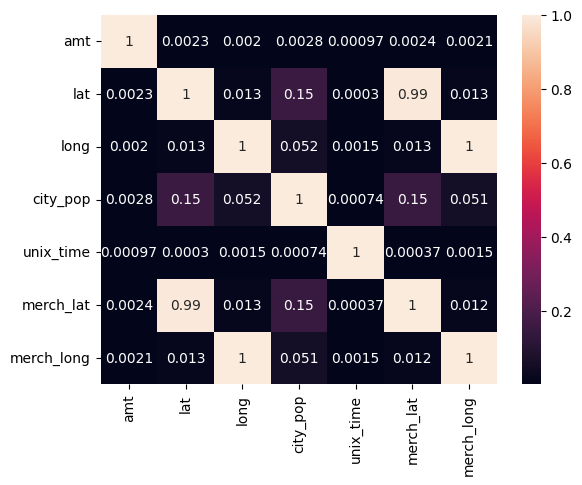

In [103]:
# creating list with numerical columns
numerical_cols = ['amt', 'lat', 'long','city_pop',\
                  'unix_time', 'merch_lat', 'merch_long']

# find highly correlated features
corr_matrix =  creditcard_df[numerical_cols].corr().abs()

# find highly correlated features
sns.heatmap(data = creditcard_df[numerical_cols].corr().abs(), 
                annot=True) 
plt.show()


In [104]:
# select upper triangle of corr_matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
drop_columns = [column for column in upper.columns if any(upper[column] > 0.95)]

drop_columns

# drop highly correlated features
creditcard_df.drop(drop_columns, axis=1, inplace=True)

# After removing unwanted features
print(f"Rows: {creditcard_df.shape[0]} and columns: {creditcard_df.shape[1]} ")

Rows: 555719 and columns: 20 


**Comments:**<br>
>  The dataset contained 555,719 observations and 23 fields. The column 'Unnamed: 0' is a unique identifier of the observation. It doesn't provide additional value, so the field has been dropped. Any features with a correlation value >0.95 are considered extremely correlated. Highly correlated features create multicollinearity, making it difficult to determine the individual effect of each independent variable on the dependent variable. Two features are highly correlated, and those features are dropped from the data set. Also, the dataset contains no missing values and no duplicate observations.

**Exploratory Data Analysis:**

In [105]:
# describe the dataframe creditcard_df
creditcard_df.describe().transpose()

,count,mean,...,75%,max
cc_num,555719.0,4.178387e+17,...,4.635331e+15,4.992346e+18
amt,555719.0,6.939281e+01,...,8.301000e+01,2.276811e+04
zip,555719.0,4.884263e+04,...,7.201100e+04,9.992100e+04
lat,555719.0,3.854325e+01,...,4.189480e+01,6.568990e+01
long,555719.0,-9.023133e+01,...,-8.017520e+01,-6.795030e+01
city_pop,555719.0,8.822189e+04,...,1.968500e+04,2.906700e+06
unix_time,555719.0,1.380679e+09,...,1.385867e+09,1.388534e+09
is_fraud,555719.0,3.859864e-03,...,0.000000e+00,1.000000e+00


In [106]:
# print number of fraud and non-fraud transactions
display(creditcard_df['is_fraud'].value_counts())

is_fraud
0    553574
1      2145
Name: count, dtype: int64

**Comments:**<br>
>   The dataset has 2145 fraudulent(1) observations and 553574 non-fraudulent (0) observations. It implies that the dataset is highly imbalanced and may create biased results. The imbalanced dataset must be handled before inputting the data to the model. The feature amount's minimum value is 1, and the maximum is 22,768.

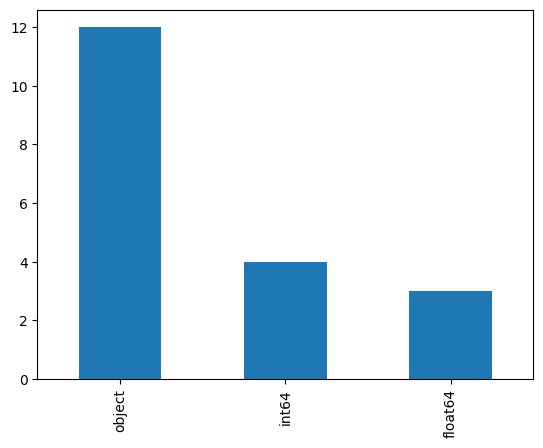

In [107]:
# plot bar graph to explore the datatypes
creditcard_df.loc[:, creditcard_df.columns != 'is_fraud'].\
dtypes.value_counts().plot(kind='bar')
plt.show()

**Comments:**
> There are multiple non numeric fields, it needs to go for categorical encoding

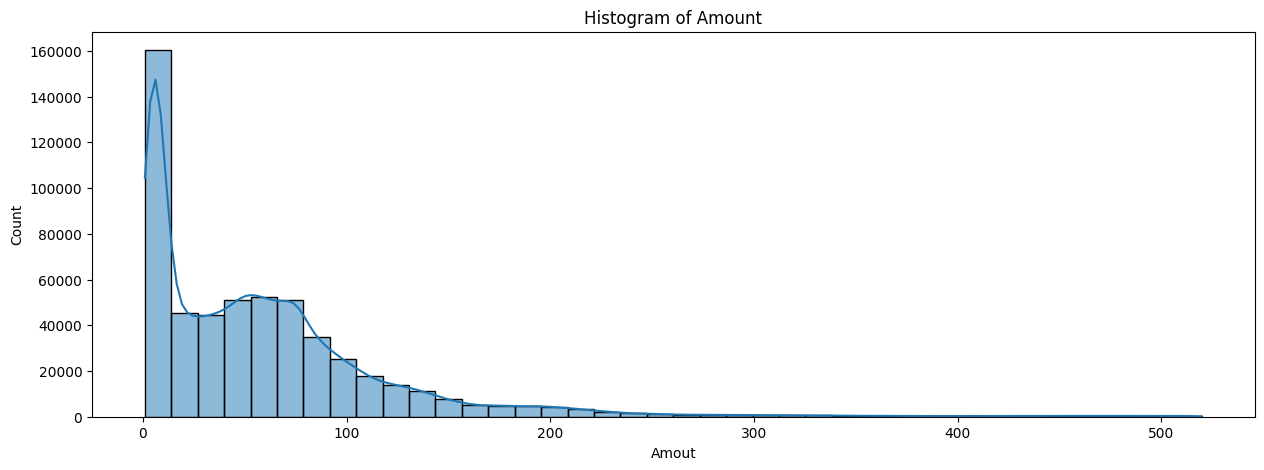

In [108]:
# histplot for Amount

# set figure size
fig, ax = plt.subplots(figsize=(15,5))

# set title
ax.set_title("Histogram of Amount")
ax.set_xlabel('Amout')

# creating dataframe
creditcard_amt_df = creditcard_df[creditcard_df["amt"]<=\
creditcard_df["amt"].quantile(0.99)][["amt","is_fraud"]]

# plot histogram
sns.histplot(creditcard_amt_df["amt"], bins=40, kde=True, ax=ax)

plt.savefig('images/Histogram_of_Amount.png', bbox_inches='tight')

# show the plot
plt.show()

**Comments:**
> The higher amount misinterprets the histogram. Hence, the 0.99 quantile was used to remove the noise. The histogram shows that the data is skewed right.

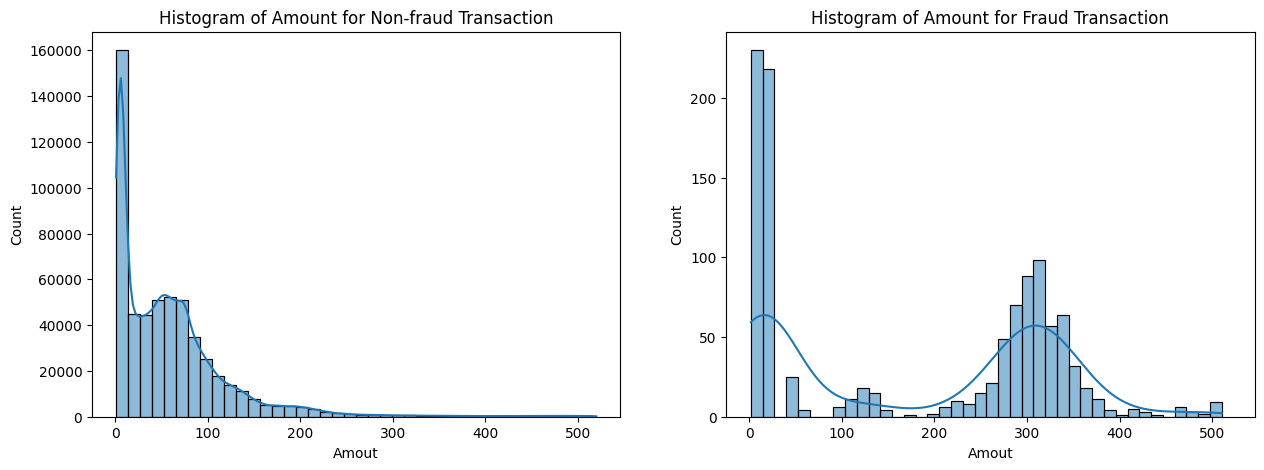

In [109]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
# plot histogram of transactino amount for fraud and non fraud transaction
sns.histplot(data=creditcard_amt_df[creditcard_amt_df['is_fraud']==0],\
             x='amt', bins=40, kde=True, ax=ax[0])
sns.histplot(data=creditcard_amt_df[creditcard_amt_df['is_fraud']==1],\
             x='amt', bins=40, kde=True, ax=ax[1])

# set the plot titles
ax[0].set_xlabel('Amout')
ax[1].set_xlabel('Amout')
ax[0].set_title('Histogram of Amount for Non-fraud Transaction')
ax[1].set_title('Histogram of Amount for Fraud Transaction')
# show the plot
plt.show()

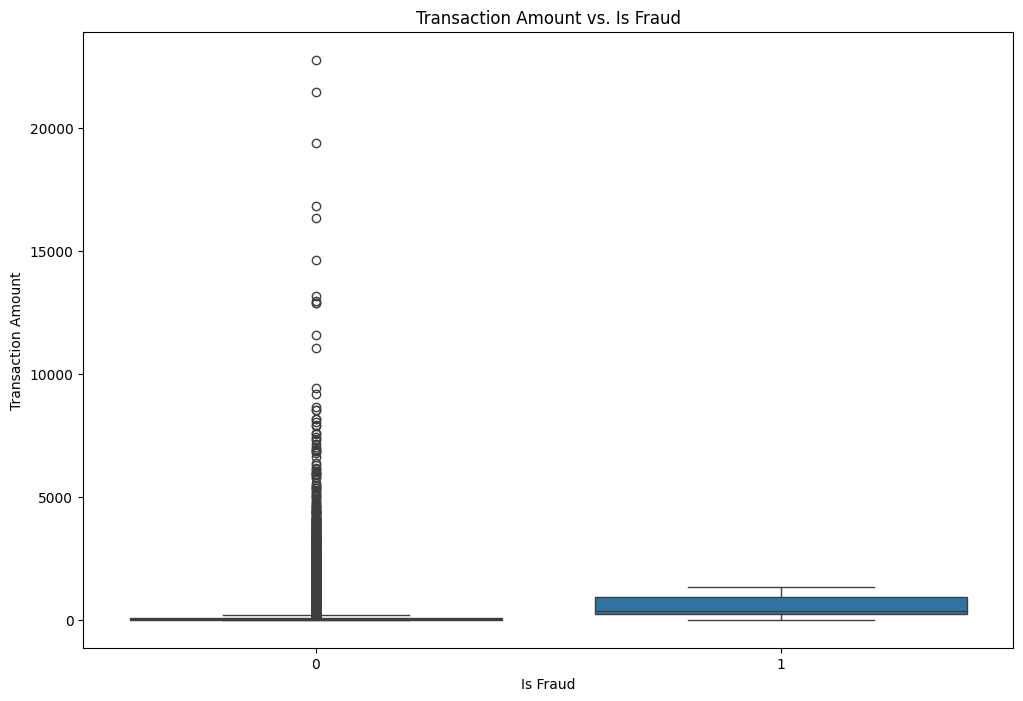

In [110]:
# Explore the distribution of transaction amounts by fraud status

# set figure size
plt.figure(figsize=(12, 8))

# plot boxplot
sns.boxplot(x='is_fraud', y='amt', data=creditcard_df)

# set title and labels
plt.title('Transaction Amount vs. Is Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')

plt.savefig('images/box_plot_transaction_amount_fraud_flag.png', bbox_inches='tight')
# show the plot
plt.show()

**Comments:**<br>
>  The box plot to have been used visualize the distribution of transaction amounts by fraud status. It is interesting to note that all fraudulent transactions are low-value transactions(less than 150).

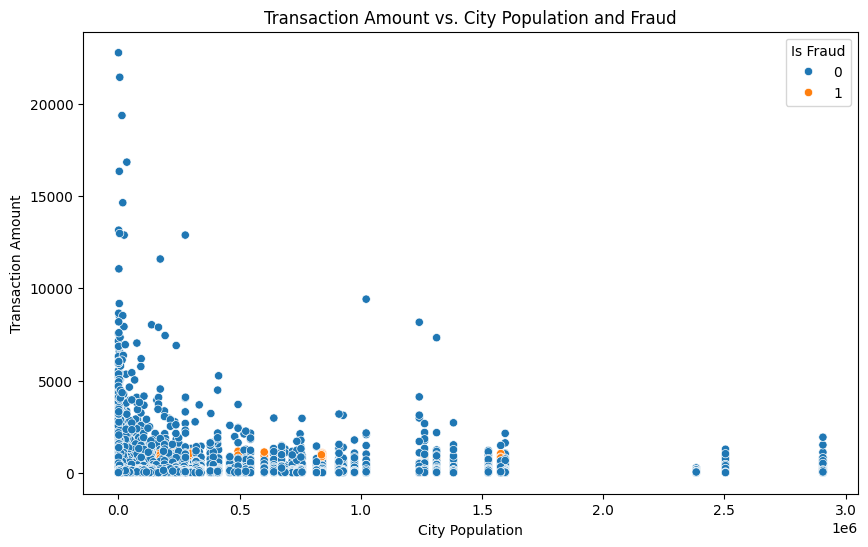

In [111]:
# Transaction Amount vs. City Population

# set figure size
plt.figure(figsize=(10, 6))

# plot scatter plot
sns.scatterplot(x='city_pop', y='amt', hue='is_fraud', data=creditcard_df)

# set title and labels
plt.title('Transaction Amount vs. City Population and Fraud')
plt.xlabel('City Population')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud')

plt.savefig('images/scatter_plot_transaction_amount_vs_city_fraud_flag.png', bbox_inches='tight')

# show the plot
plt.show()

**Comment:**
> The scatter plot have been used to visualize the transaction amount vs city population by fraud status. It shows a weak correlation for both fraudulent and non-fraudulent transactions.

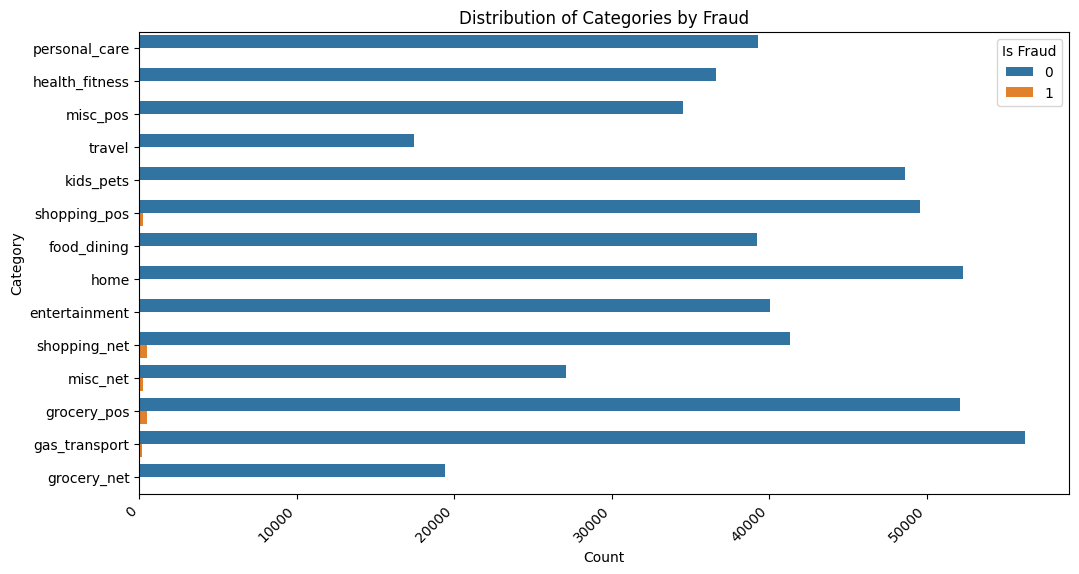

In [112]:
# Explore categorical features

# set figure size
plt.figure(figsize=(12, 6))

# plot countplot
sns.countplot(y='category', hue='is_fraud', data=creditcard_df)

# set title and labels
plt.title('Distribution of Categories by Fraud')
plt.xlabel('Count')
plt.ylabel('Category')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Is Fraud')

plt.savefig('images/Distribution_of_Categories_by_Fraud.png', bbox_inches='tight')
# show the plot
plt.show()

**Comments:**<br>
>  It is interesting to note most of the fraud happened in the categories shopping_POS, shopping_net, misc_net, grocery_pos, and gas_transport.

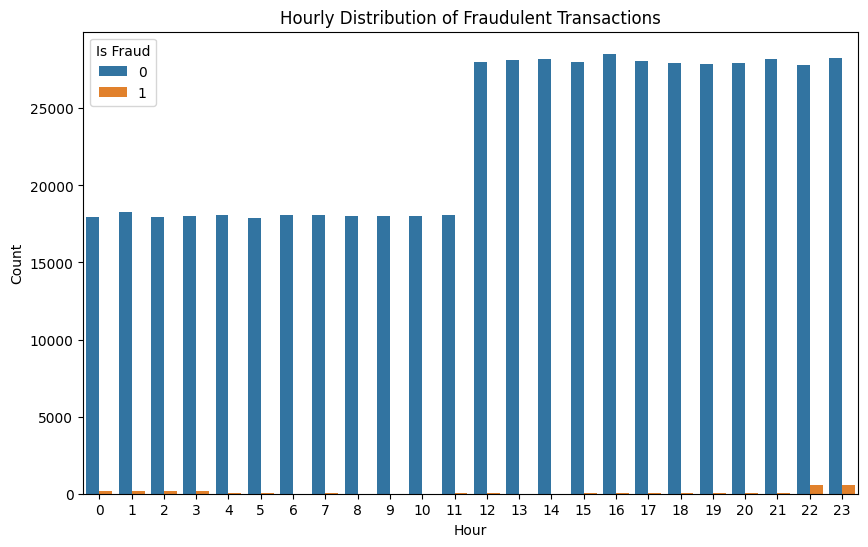

In [113]:
# Analysing datetime feature trans_date_trans_time

# extract hour from timestamp column
creditcard_df['trans_hour'] = pd.to_datetime(creditcard_df['trans_date_trans_time']).\
dt.hour

# set figure size
plt.figure(figsize=(10, 6))

# plot countplot
sns.countplot(x='trans_hour', hue='is_fraud', data=creditcard_df)

# set title and labels
plt.title('Hourly Distribution of Fraudulent Transactions')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Is Fraud')

plt.savefig('images/Hourly_Distribution_of_Fraudulent_Transactions.png', bbox_inches='tight')
# show the plot
plt.show()

**Comments:**
> It is interesting to note that most fraudulent transactions happened between 10 PM and 3 AM at night.

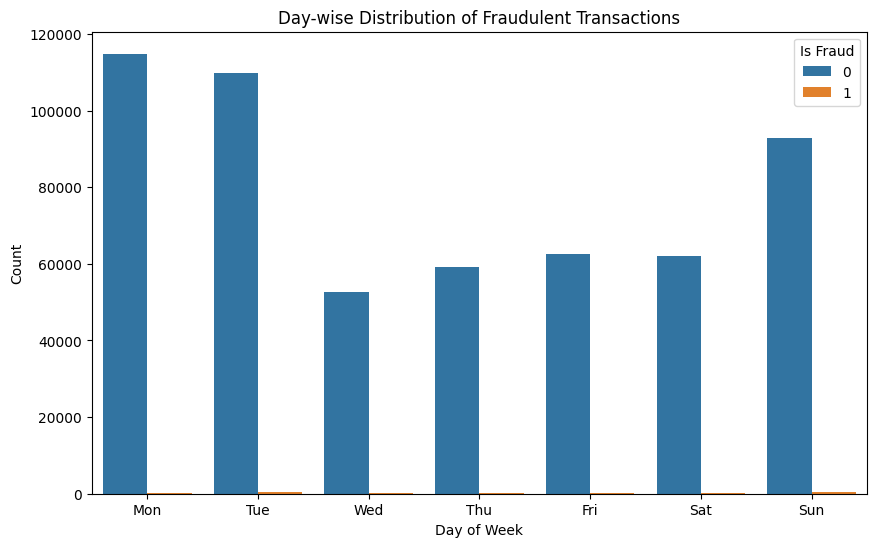

In [114]:
# extract day of the week
creditcard_df['trans_day'] = pd.to_datetime(creditcard_df['trans_date_trans_time']).\
dt.dayofweek

# set figure size
plt.figure(figsize=(10, 6))

# plot countplot
sns.countplot(x='trans_day', hue='is_fraud', data=creditcard_df)

# set title and labels
plt.title('Day-wise Distribution of Fraudulent Transactions')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Is Fraud')

# show the plot
plt.show()

**Comments:**
> The day-wise visualization shows that Sundays and Tuesdays have more fraudulent transactions. 

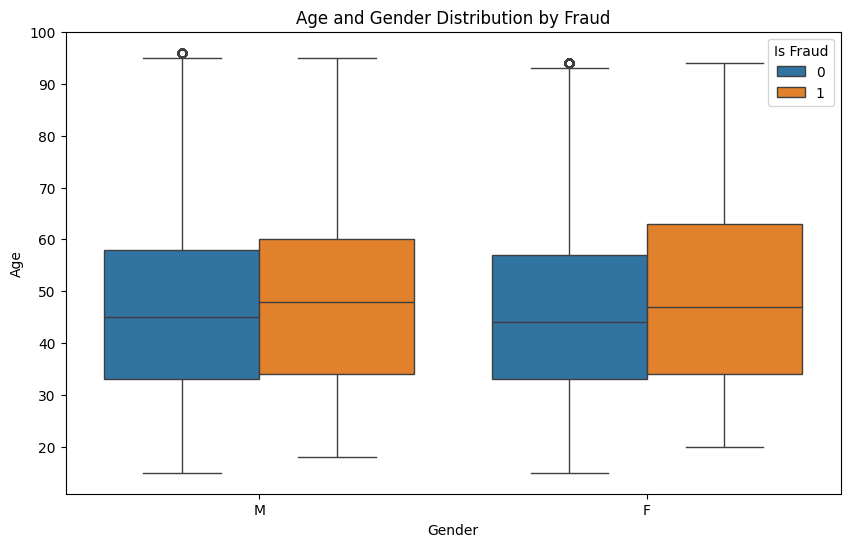

In [115]:
# get the age of the cardholder
creditcard_df['trans_date_trans_time'] =\
pd.to_datetime(creditcard_df['trans_date_trans_time'])
creditcard_df['dob'] = pd.to_datetime(creditcard_df['dob'])
creditcard_df['age'] =\
(creditcard_df['trans_date_trans_time'] - creditcard_df['dob']).dt.days // 365

# set figure size
plt.figure(figsize=(10, 6))

# plot boxplot
sns.boxplot(x='gender', y='age', hue='is_fraud', data=creditcard_df)

# set title and labels
plt.title('Age and Gender Distribution by Fraud')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Is Fraud')

# show the plot
plt.show()

**Comments:**
> Most of the fraud transactions happened in the age group between 30 and 60 for both males and females.

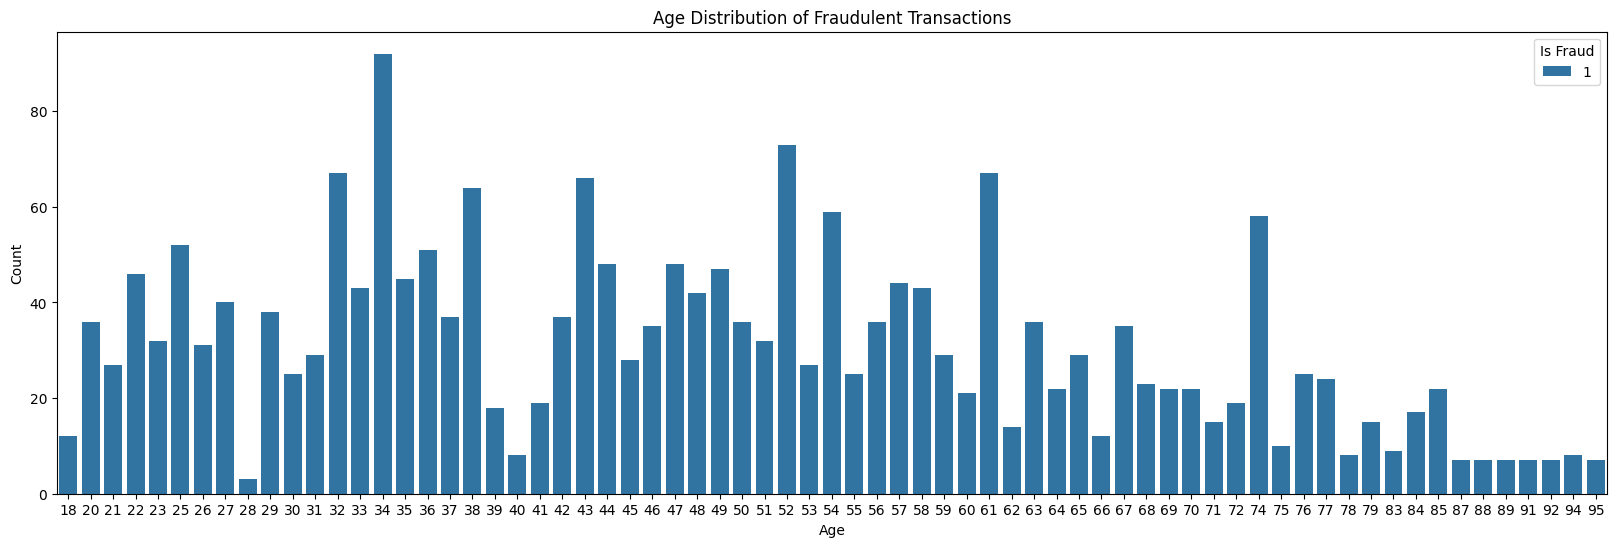

In [116]:
# set figure size
plt.figure(figsize=(20, 6))

# plot countplot
sns.countplot(x='age', hue='is_fraud', data=creditcard_df[creditcard_df['is_fraud']==1])

# set title and labels
plt.title('Age Distribution of Fraudulent Transactions')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Is Fraud')

plt.savefig('images/Age_Distribution_of_Fraudulent_Transactions.png', bbox_inches='tight')
# show the plot
plt.show()

**comment**:
> Transactions associated with age 34 have the highest number of fraud transactions, followed by 52,32, 43, and 61.


**DATA PREPARE:**

In [117]:
# create dataframe with predictor variables
creditcard_pred_df = creditcard_df.loc[:, creditcard_df.columns != 'is_fraud']

# create dataframe for target variable
creditcard_resp_df = creditcard_df['is_fraud']

In [118]:
# dropping columns which are not useful 
creditcard_pred_df.\
drop(columns=["merchant", "first", "last",\
              "street", "dob","trans_date_trans_time",'city','trans_num'],\
     inplace=True)

In [119]:
# split the data into train and test
X_train, X_test, y_train, y_test =\
train_test_split(creditcard_pred_df,\
                 creditcard_resp_df,\
                 test_size=0.3, random_state=42,\
                 stratify=creditcard_df['is_fraud'].values,\
                 shuffle=True)

In [120]:
# categorical column list
categorical_cols = ['gender', 'category', 'state']

# Transforming
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     categorical_cols))

# fit and transform tranining dataset
transformed_train = transformer.fit_transform(X_train[categorical_cols]).toarray()

# Transformating back
transformed_train_df = pd.DataFrame(transformed_train,\
                                    columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_train_df.index = X_train[categorical_cols].index
# Joining tables
X_train_encoded = pd.concat([X_train[categorical_cols], transformed_train_df], axis=1)
X_train_encoded.drop(categorical_cols, axis=1, inplace=True)

In [121]:
# transform test dataset
transformed_test = transformer.transform(X_test[categorical_cols]).toarray()

# Transformating back
transformed_test_df = pd.DataFrame(transformed_test,\
                                   columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_test_df.index = X_test[categorical_cols].index
# Joining tables
X_test_encoded = pd.concat([X_test[categorical_cols], transformed_test_df], axis=1)
X_test_encoded.drop(categorical_cols, axis=1, inplace=True)


In [122]:
# standardize the numerical varaibles 
scaler = StandardScaler()
numerical_cols = ['cc_num', 'amt', 'zip', 'lat',
       'long', 'city_pop', 'trans_hour',
       'trans_day', 'age']
# fit and transform tranining dataset
X_train_sc_features = scaler.fit_transform(X_train[numerical_cols])

#  transform test dataset
X_test_sc_features = scaler.transform(X_test[numerical_cols])

In [123]:
# create dataframe for scaled features
X_train_sc_features_df= pd.DataFrame(X_train_sc_features,columns=numerical_cols)
X_test_sc_features_df = pd.DataFrame(X_test_sc_features,columns=numerical_cols)

In [124]:
# Concatenate encoded and scaled features for both train and test data
X_train_features_final = pd.concat([X_train_encoded.\
                                    reset_index(drop=True),\
                                    X_train_sc_features_df.reset_index(drop=True) ],\
                                   axis=1)
X_test_feature_final = pd.concat([X_test_encoded.\
                                  reset_index(drop=True),\
                                  X_test_sc_features_df.reset_index(drop=True) ],\
                                 axis=1)

In [125]:
pd.DataFrame(X_train_sc_features,columns=numerical_cols).shape

(389003, 9)

In [126]:
X_train_features_final.shape

(389003, 75)

**Comment:**
> The dataset didn't have any duplicates or null attributes. Extremely correlated fields are removed from the dataset. The following data preparation steps have been conducted: 
 New feature age is extracted using dob and transaction time. New features' hours and days are selected from transaction date time after extraction features dob and transaction date time are removed from the dataset.
Column merchants, first and last names, and streets are not helpful. These features are dropped from the dataset. 
Split the data into training and test sets. 70 % of the dataset set was assigned for training, and 30 % was allocated for testing. 
One hot encoding technique is applied to categorical variables, such as state, category, job, and gender, to convert them into numerical values.
The standard scalar technique is applied to numerical variable variables to standardize the data values.

**Model:**

In [127]:
# create dict for list of models
model_dict = {
    'LogisticRegression': LogisticRegression(solver='liblinear',multi_class='ovr'),
              'DecisionTreeClassifier': DecisionTreeClassifier(),
              'RandomForest': RandomForestClassifier(n_estimators = 50),
            'XGBClassifier': xgb.XGBClassifier()
             }
model_dict

{'LogisticRegression': LogisticRegression(multi_class='ovr', solver='liblinear'),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'RandomForest': RandomForestClassifier(n_estimators=50),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}

In [128]:
# create dict to store the fitted model
fitted_model_dict = {}

# create empty dataframe
model_performance_df = pd.DataFrame(columns =\
                                    [ 'accuracy', 'precision','recall',\
                                     'f1_score','roc_auc'])
# iterating through each model in the dictionary
for model_name, model_instance in model_dict.items():
    model = model_instance.fit(X_train_features_final, y_train)
    fitted_model_dict[model_name] = model
    model_predict = model.predict(X_test_feature_final)
    # model_score = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, model_predict)
    precision = precision_score(y_test, model_predict)
    recall = recall_score(y_test, model_predict)
    f1 = f1_score(y_test, model_predict)
    roc_auc = roc_auc_score(y_test, model_predict)    
    model_performance_df.loc[model_name] =[accuracy, precision,recall, f1,roc_auc ]

# print models performance metrics
    
display(model_performance_df)

    

,accuracy,precision,recall,f1_score,roc_auc
LogisticRegression,0.995963,0.000000,0.000000,0.000000,0.499913
DecisionTreeClassifier,0.998189,0.746398,0.804348,0.774290,0.901644
RandomForest,0.998530,0.973872,0.636646,0.769953,0.818290
XGBClassifier,0.999064,0.943636,0.805901,0.869347,0.902857


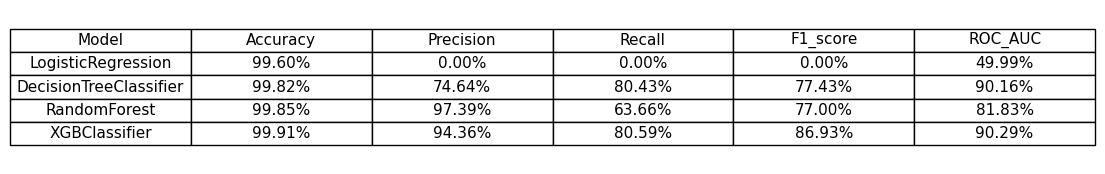

In [129]:
model_performance_with_label_df = model_performance_df.reset_index()
model_performance_with_label_df.columns = ['Model','Accuracy','Precision','Recall','F1_score','ROC_AUC']

for column in ['Accuracy','Precision','Recall','F1_score','ROC_AUC']:
    model_performance_with_label_df[column] = model_performance_with_label_df[column].apply(lambda x: f"{x:.2%}")

fig, ax = plt.subplots(figsize=(10,2))
ax.axis('tight')
ax.axis('off')
table=ax.table(cellText=model_performance_with_label_df.values,colLabels=model_performance_with_label_df.columns,cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.4,1.4)
plt.savefig('images/comparison_of_the_performance_metrics.png', bbox_inches='tight')
plt.show()

In [130]:
# select the model
selected_model = fitted_model_dict['XGBClassifier']

# get the important feature
feature_importances = pd.Series(selected_model.feature_importances_,\
                                index=X_train_features_final.columns)

# sort values 
feature_importances.sort_values(ascending=False, inplace=True)

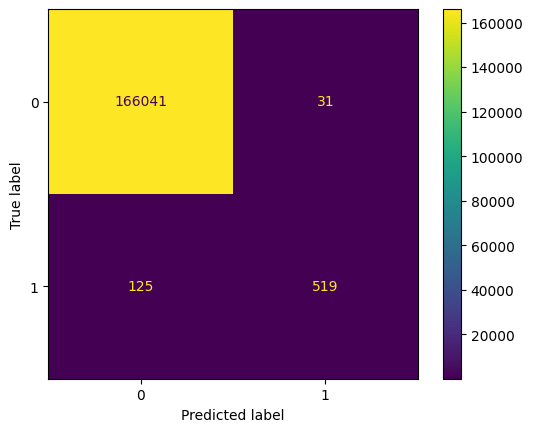

In [131]:
# print the confusion matrix for the selected model
predictions = selected_model.predict(X_test_feature_final)
cm = confusion_matrix(y_test, predictions, labels=selected_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,\
                              display_labels=selected_model.classes_)
disp.plot()
plt.savefig('images/confusion_matrix.png', bbox_inches='tight')
plt.show()

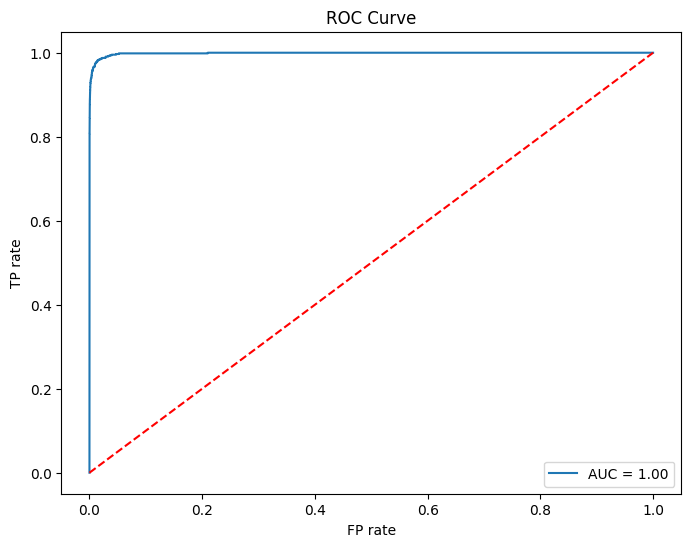

In [132]:
# find predict probalility 
y_pred_proba = selected_model.predict_proba(X_test_feature_final)[::,1]
fp_r, tp_r, t = roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
# plot roc curve
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")

# set labels and title
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")

plt.savefig('images/roc_curve.png', bbox_inches='tight')

# show plot
plt.show()

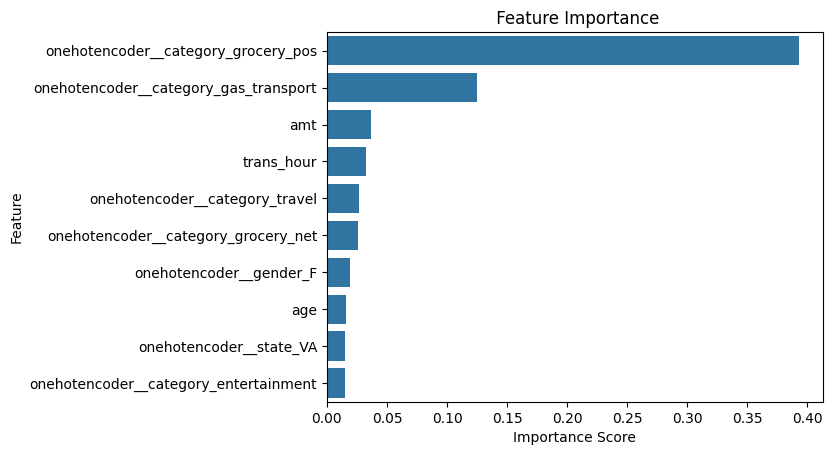

In [133]:
# plot top importances features
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)

# set labels
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title(" Feature Importance")
plt.savefig('images/importances_features.png', bbox_inches='tight')
#  show the plot
plt.show()

**Interpreting results:**

Classification techniques have been used to solve credit card fraud detection. Multiple models, such as logistic regression, decision trees, XGBClassifier, and random forests, are used for credit card fraud detection. Logistic regression was used because credit card fraud detection needed binary output. It returns the probability, and 0.5 has been set as the threshold. i.e., if any value is greater than 0.5, it will predict output as 1. Otherwise, it predicts the output as 0. The decision tree is a commonly used algorithm for the classification problem. The first node in decision trees contains the most critical feature, while the following nodes contain the least vital features. Decision trees assist users in determining which attributes have the most significant influence on their prediction tasks. A random Forest is used because this model reduces overfitting and has better accuracy than other models. The training dataset is quite large. The ensemble machine learning model XGBClassifier would also be a good fit. It has higher predicting power and performance and is achieved by improvisation on the Gradient Boosting framework.
Accuracy is often used to measure classification performance because it is simple to compute and interpret. It tells the percentage of correct predictions made by a model. Precision is another evaluation metric used for classification problems. Metric precision helps to evaluate the quality of a positive prediction made by the model. A higher precision score indicates that the model makes fewer false positive predictions. The F1 score is used because it helps find the classifier's quality. A higher F1 score denotes better quality. The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes. An AUC score of 1 means the classifier can perfectly distinguish between all the Positive and the Negative class points. 


**Conclusion and Recommendation:**
> The project's primary goal is to identify credit card fraud transactions to prevent revenue loss and reputation damage to financial institutions. The XGBClassifier model yielded better results with an accuracy greater than 99 %. A feature importance plot has been created to identify the features which have a higher effect on the model. The feature grocery point-of-sales transactions are at the top of the list, followed by gas transport, amount, transaction hour, and travel.  

> From the EDA, we noticed that all the fraudulent transactions have amounts less than 150  and that most credit card fraudulent transactions happen between 10 PM and 3 AM. Also, we noted that grocery POS, gas transport, and grocery net have a lot of fraudulent transactions. Transactions involving the ages 34, 52, 32, 61, and 43 accounted for more fraudulent transactions. A good starting point is to use the XGBClassifier model to flag the transactions as suspicious before processing. If the transaction falls into the above important feature category, it will likely be fraudulent.